#  eCommerce purchase prediction

Importing packages

In [1]:
import pandas as pd
import numpy as np

import datetime 
import time

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from easygui import fileopenbox

In [66]:
#Let us load the Retail Rocket CSV files into DataFrames
E=fileopenbox()

In [67]:
C=fileopenbox()

In [68]:
I_one=fileopenbox()

In [69]:
I_two=fileopenbox()

In [72]:
Events=pd.read_csv(E)

In [73]:
Category=pd.read_csv(C)

In [74]:
Item_properties_1=pd.read_csv(I_one)

In [75]:
Item_properties_2=pd.read_csv(I_two)

In [76]:
#Let's take a peek at the Events dataframe
Events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [77]:
Events['timestamp']=pd.to_datetime(Events['timestamp'])

In [78]:
Events

,timestamp,visitorid,event,itemid,transactionid
0,1970-01-01 00:23:53.221332117,257597,view,355908,NaN
1,1970-01-01 00:23:53.224214164,992329,view,248676,NaN
2,1970-01-01 00:23:53.221999827,111016,view,318965,NaN
3,1970-01-01 00:23:53.221955914,483717,view,253185,NaN
4,1970-01-01 00:23:53.221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1970-01-01 00:23:58.398785939,591435,view,261427,NaN
2756097,1970-01-01 00:23:58.399813142,762376,view,115946,NaN
2756098,1970-01-01 00:23:58.397820527,1251746,view,78144,NaN
2756099,1970-01-01 00:23:58.398530703,1184451,view,283392,NaN


In [79]:
#The timestamp portionis in Unix Epoch format e.g. 1433221332117 will be converted to Tuesday, 2 June 2015 5:02:12.117 AM GMT
#Visitor Id is the unique user currently browsing the website
#Event is what the user is currently doing in that current timestamp
#Transaction ID will only have value if the user made a purchase as shown below

In [80]:
#Which event has a value in its transaction id
Events[Events.transactionid.notnull()].event.count()

22457

In [81]:
Events[Events.transactionid.notnull()].event.unique()

array(['transaction'], dtype=object)

In [82]:
#The rest of the events with NaN transaction ids are either view or add to cart

Now let's take a look at the Item Properties

In [83]:
Events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1970-01-01 00:23:53.221332117,257597,view,355908,NaN
1,1970-01-01 00:23:53.224214164,992329,view,248676,NaN
2,1970-01-01 00:23:53.221999827,111016,view,318965,NaN
3,1970-01-01 00:23:53.221955914,483717,view,253185,NaN
4,1970-01-01 00:23:53.221337106,951259,view,367447,NaN


In [84]:
Category.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [85]:
Item_properties_1.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [86]:
Item_properties_2.head()

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062


In [87]:
Item_properties_2['property'].unique()

array(['561', '976', '921', ..., '1091', '522', '769'], dtype=object)

In [88]:
#Category IDs explain the relationship of different products with each other

In [89]:
Category.categoryid.value_counts()

1697    1
1274    1
1120    1
1122    1
1124    1
       ..
577     1
579     1
581     1
583     1
0       1
Name: categoryid, Length: 1669, dtype: int64

In [90]:
Item_properties_1.loc[(Item_properties_1.property == 'categoryid') & (Item_properties_1.value == '1016')].sort_values('timestamp').head()

,timestamp,itemid,property,value
6363096,1431226800000,339403,categoryid,1016
8597591,1431226800000,161686,categoryid,1016
7942027,1431226800000,418837,categoryid,1016
10230975,1431226800000,85538,categoryid,1016
7280176,1431226800000,278463,categoryid,1016


In [91]:
#Customer behaviour exploration

WE will  start separating customers into two categories, those who purchased something and those who didn't

In [92]:
Events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1970-01-01 00:23:53.221332117,257597,view,355908,NaN
1,1970-01-01 00:23:53.224214164,992329,view,248676,NaN
2,1970-01-01 00:23:53.221999827,111016,view,318965,NaN
3,1970-01-01 00:23:53.221955914,483717,view,253185,NaN
4,1970-01-01 00:23:53.221337106,951259,view,367447,NaN


In [93]:
customer_purchased=Events[Events.transactionid.notnull()].visitorid.unique()

In [94]:
customer_purchased.size


11719

1. Since we have no information whether there were any repeat users who bought something from the site, I'll just have to assume for now that the 11,719 visitors are unique and made at least a single purchase

In [96]:
#Let's get all unique visitor ids as well
All_customers=Events.visitorid.unique()
All_customers.size


1407580

In [98]:
#Out of 1,407,580 unique visitor ids, let's take out the ones that did  bought something
customer_browsed=[x for x in All_customers if x not in customer_purchased]

In [99]:
len(customer_browsed)
#Since it is in list..

1395861

So there are 1395861 unique site visitors who didn't buy anything,again assuming that there were no repeat users with different visitor IDs

In [82]:
#WE can also do it in numpy
temp_array=np.isin(customer_browsed,customer_purchased)
temp_array[temp_array==False].size

1395861

In [100]:
customer_purchased[:10]

array([ 599528,  121688,  552148,  102019,  189384,  350566,  404403,
        505565,  945184, 1406787], dtype=int64)

In [101]:
pd.set_option('display.max_rows',50)

In [102]:
Events

,timestamp,visitorid,event,itemid,transactionid
0,1970-01-01 00:23:53.221332117,257597,view,355908,NaN
1,1970-01-01 00:23:53.224214164,992329,view,248676,NaN
2,1970-01-01 00:23:53.221999827,111016,view,318965,NaN
3,1970-01-01 00:23:53.221955914,483717,view,253185,NaN
4,1970-01-01 00:23:53.221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1970-01-01 00:23:58.398785939,591435,view,261427,NaN
2756097,1970-01-01 00:23:58.399813142,762376,view,115946,NaN
2756098,1970-01-01 00:23:58.397820527,1251746,view,78144,NaN
2756099,1970-01-01 00:23:58.398530703,1184451,view,283392,NaN


In [103]:
Events.columns

Index(['timestamp', 'visitorid', 'event', 'itemid', 'transactionid'], dtype='object')

In [104]:
Events.visitorid.value_counts

<bound method IndexOpsMixin.value_counts of 0           257597
1           992329
2           111016
3           483717
4           951259
            ...   
2756096     591435
2756097     762376
2756098    1251746
2756099    1184451
2756100     199536
Name: visitorid, Length: 2756101, dtype: int64>

Below is a snapshot of visitor id 102019 and their buying journey from viewing to transaction (purchase)

In [105]:
Events[Events.visitorid==483717].sort_values('timestamp')
#So this visitorid_483717 has only viewed it

,timestamp,visitorid,event,itemid,transactionid
8048,1970-01-01 00:23:53.221804507,483717,view,253185,NaN
16809,1970-01-01 00:23:53.221871581,483717,view,353936,NaN
3,1970-01-01 00:23:53.221955914,483717,view,253185,NaN


What insights can we offer the visitor to guide them in their buying journey?

In [108]:
customer_purchased = Events[Events.transactionid.notnull()].visitorid.unique()

In [109]:
customer_purchased

array([ 599528,  121688,  552148, ..., 1155978, 1050575,  855941],
      dtype=int64)

In [111]:
purchased_items = []
# Create another list that contains all their purchases 
for i in customer_purchased:
    purchased_items.append(list(Events.loc[(Events.visitorid==i)& (Events.transactionid.notnull())].itemid.values))

In [112]:
purchased_items


[[356475],
 [15335,
  380775,
  237753,
  317178,
  12836,
  400969,
  105792,
  25353,
  200793,
  80582,
  302422],
 [81345],
 [150318, 49521],
 [310791, 299044],
 [54058,
  284871,
  251130,
  268335,
  183049,
  261940,
  369093,
  370745,
  192990,
  277119,
  241716,
  283766,
  16417,
  217068,
  36372,
  68923,
  428015,
  69533,
  13520,
  385638,
  442871,
  136526,
  247862,
  93828,
  230911,
  382595,
  34853,
  216260,
  154812,
  445241,
  57702,
  347850,
  151855,
  226327,
  288525,
  51354,
  345994,
  170438,
  254301,
  266439,
  193718,
  388558,
  26745,
  184086,
  79956,
  252040,
  82232,
  309821,
  394518,
  462070,
  331980,
  353111,
  200527,
  235933,
  68532,
  358882,
  60012,
  29741,
  270487,
  163689,
  6913,
  156457,
  341578,
  163352,
  234493,
  135174,
  452481,
  241755,
  56323,
  210137,
  184397,
  285202,
  198690,
  195958,
  239210,
  71640,
  189108,
  369112,
  346186,
  211207,
  134330,
  257070,
  302239,
  459480,
  57577,
  1952

In [113]:

# Write a function that would show items that were bought together (same of different dates) by the same customer
def recommender_bought_bought(item_id, purchased_items):
    
    # Perhaps implement a binary search for that item id in the list of arrays
    # Then put the arrays containing that item id in a new list
    # Then merge all items in that list and get rid of duplicates
    recommender_list = []
    for x in purchased_items:
        if item_id in x:
            recommender_list += x
    
    #Then merge recommender list and remove the item id
    recommender_list = list(set(recommender_list) - set([item_id]))
    
    return recommender_list

So now we can present to the visitor a list of the other items a customer previously
bought along with what item the current visitor is viewing e.g. item number 302422

In [114]:
recommender_bought_bought(80582,purchased_items)

[105792, 200793, 12836, 380775, 15335, 400969, 25353, 302422, 237753, 317178]

In [115]:
#That was a very crude way of recommending other items to the visitor

What other insights can we gather from the items that were viewed, added to cart and sold?¶

In [116]:
Events['event'].value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [117]:
Events.columns

Index(['timestamp', 'visitorid', 'event', 'itemid', 'transactionid'], dtype='object')

In [118]:
All_visitors=Events.visitorid.sort_values().unique()

In [119]:
All_visitors.size

1407580

In [121]:
#Buying visitors
Buying_visitors=Events[Events.event=='transaction'].visitorid.sort_values().unique()

In [122]:
Buying_visitors.size

11719

Out of 1407580 visitors, only  11719  bought goods where as 13,95,861 only view the product 
so 0.8% people  is the purcahse rate where as 99.16%  is the non-Purchase rate

In [123]:
viewing_visitors_list = list(set(All_visitors) - set(Buying_visitors))

In [124]:
len(viewing_visitors_list)

1395861

In [125]:
 def create_dataframe(visitor_list):
    
    array_for_df = []
    for index in visitor_list:

        #Create that visitor's dataframe once
        v_df = Events[Events.visitorid == index]

        temp = []
        #Add the visitor id
        temp.append(index)

        #Add the total number of unique products viewed
        temp.append(v_df[v_df.event == 'view'].itemid.unique().size)

        #Add the total number of views regardless of product type
        temp.append(v_df[v_df.event == 'view'].event.count())

        #Add the total number of purchases
        number_of_items_bought = v_df[v_df.event == 'transaction'].event.count()
        temp.append(number_of_items_bought)

        #Then put either a zero or one if they made a purchase
        if(number_of_items_bought == 0):
            temp.append(0)
        else:
            temp.append(1)

        array_for_df.append(temp)
    
    return pd.DataFrame(array_for_df, columns=['visitorid', 'num_items_viewed', 'view_count', 'bought_count', 'purchased'])


In [126]:
Buying_visitors

array([    172,     186,     264, ..., 1407070, 1407110, 1407398],
      dtype=int64)

In [128]:
buying_visitors_df=create_dataframe(Buying_visitors)

In [130]:
buying_visitors_df

,visitorid,num_items_viewed,view_count,bought_count,purchased
0,172,22,33,2,1
1,186,1,2,1,1
2,264,2,3,2,1
3,419,3,4,1,1
4,539,1,4,1,1
...,...,...,...,...,...
11714,1406787,3,20,1,1
11715,1406981,4,4,1,1
11716,1407070,1,1,1,1
11717,1407110,2,7,1,1


In [131]:
buying_visitors_df.columns

Index(['visitorid', 'num_items_viewed', 'view_count', 'bought_count',
       'purchased'],
      dtype='object')

In [132]:
len(viewing_visitors_list)

1395861

In [133]:
#11719--30%
#X--70%
(11719*70)/30


27344.333333333332

In [135]:
#Let's shuffle the viewing visitors list for randomness
import random
random.shuffle(viewing_visitors_list)

In [136]:
viewing_visitors_list

[810862,
 1389890,
 1312840,
 372741,
 89166,
 701586,
 840142,
 379082,
 336241,
 913735,
 222486,
 169228,
 808374,
 376736,
 892857,
 881748,
 329353,
 339669,
 1299644,
 1159496,
 763050,
 234653,
 124634,
 776206,
 1258551,
 147769,
 1396683,
 326039,
 664037,
 72605,
 283398,
 95956,
 1369758,
 1371719,
 1329596,
 787249,
 1378023,
 809383,
 1213840,
 1162093,
 656667,
 516398,
 56676,
 1400143,
 1230264,
 888543,
 505447,
 840971,
 1167774,
 1171624,
 475032,
 114102,
 395716,
 327682,
 1200406,
 147996,
 1292052,
 1231418,
 779495,
 25648,
 1003967,
 941817,
 583064,
 1065,
 98390,
 1089593,
 141490,
 213770,
 480390,
 192639,
 826246,
 1377943,
 223419,
 1085953,
 744089,
 1247660,
 335947,
 1366812,
 49078,
 220336,
 89742,
 1016473,
 1174733,
 264201,
 349486,
 13838,
 1198008,
 155415,
 1383515,
 787545,
 1090305,
 146733,
 309727,
 1145783,
 127094,
 442248,
 794239,
 784933,
 1308594,
 1197557,
 553575,
 1134527,
 804249,
 794409,
 1009925,
 1084656,
 692903,
 118869,
 16

In [142]:
viewing_visitors_df = create_dataframe(viewing_visitors_list[0:27344])

In [143]:
viewing_visitors_df.shape

(27344, 5)

In [144]:
viewing_visitors_df.head()
#Since we applied it to the function of create_dataframe

,visitorid,num_items_viewed,view_count,bought_count,purchased
0,810862,1,1,0,0
1,1389890,2,2,0,0
2,1312840,1,1,0,0
3,372741,1,1,0,0
4,89166,1,2,0,0


In [145]:
main_df = pd.concat([buying_visitors_df, viewing_visitors_df], ignore_index=True)

In [147]:
main_df.head()

,visitorid,num_items_viewed,view_count,bought_count,purchased
0,172,22,33,2,1
1,186,1,2,1,1
2,264,2,3,2,1
3,419,3,4,1,1
4,539,1,4,1,1


In [148]:
#Let's shuffle main_df first
main_df = main_df.sample(frac=1)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


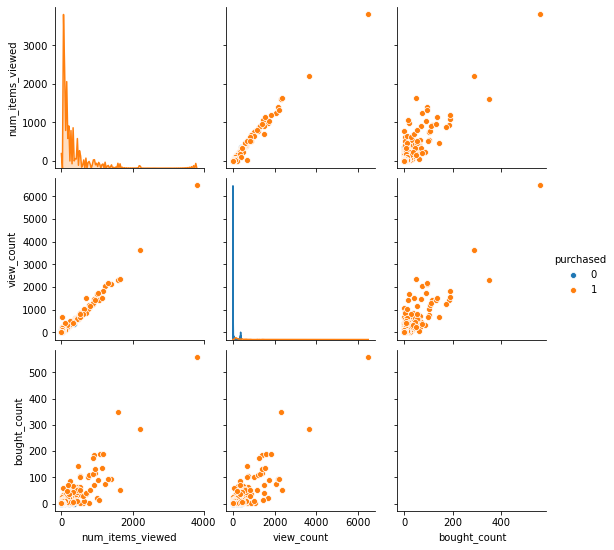

In [149]:
sns.pairplot(main_df, x_vars = ['num_items_viewed', 'view_count', 'bought_count'],
             y_vars = ['num_items_viewed', 'view_count', 'bought_count'],  hue = 'purchased')

The plot above clearly indicates that the higher the view count, the higher the chances of that visitor buying something. Duh!

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score,roc_curve

In [152]:
main_df

,visitorid,num_items_viewed,view_count,bought_count,purchased
19195,301558,1,1,0,0
4017,492470,3,6,1,1
24501,521525,1,1,0,0
10990,1320564,2,5,1,1
35815,689238,1,13,0,0
...,...,...,...,...,...
9932,1193771,6,6,2,1
29402,869346,1,1,0,0
9637,1162129,1,1,1,1
15760,1363902,1,1,0,0


In [153]:
main_df.dtypes

visitorid           int64
num_items_viewed    int64
view_count          int64
bought_count        int64
purchased           int64
dtype: object

In [154]:
main_df.describe()

,visitorid,num_items_viewed,view_count,bought_count,purchased
count,3.906300e+04,39063.000000,39063.000000,39063.000000,39063.000000
mean,7.070801e+05,3.801039,5.886773,0.574892,0.300003
std,4.053465e+05,37.640096,59.265040,4.926412,0.458265
min,1.310000e+02,0.000000,0.000000,0.000000,0.000000
25%,3.550545e+05,1.000000,1.000000,0.000000,0.000000
50%,7.090160e+05,1.000000,1.000000,0.000000,0.000000
75%,1.058803e+06,2.000000,3.000000,1.000000,1.000000
max,1.407558e+06,3809.000000,6479.000000,559.000000,1.000000


In [209]:
main_df.isnull().sum()

visitorid           0
num_items_viewed    0
view_count          0
bought_count        0
purchased           0
dtype: int64

In [159]:
inde=main_df.iloc[:,:4]
inde

,visitorid,num_items_viewed,view_count,bought_count
19195,301558,1,1,0
4017,492470,3,6,1
24501,521525,1,1,0
10990,1320564,2,5,1
35815,689238,1,13,0
...,...,...,...,...
9932,1193771,6,6,2
29402,869346,1,1,0
9637,1162129,1,1,1
15760,1363902,1,1,0


In [160]:
dep=main_df['purchased']
dep_df=pd.DataFrame(y)

In [161]:
dep_df['purchased'].value_counts()/y_df.shape[0]
#70-30 More likely balanced data

0    0.699997
1    0.300003
Name: purchased, dtype: float64

In [164]:
from imblearn.over_sampling import SMOTE as sm
oversample=sm()
x,y=oversample.fit_resample(inde,dep)

In [168]:
y_df=pd.DataFrame(y)
y_df['purchased'].value_counts()

1    27344
0    27344
Name: purchased, dtype: int64

# Feature importance

In [198]:
from sklearn.ensemble import ExtraTreesClassifier
model=ExtraTreesClassifier()
model.fit(x,y)
print(model.feature_importances_)

[0.00111346 0.08258094 0.11499132 0.80131428]


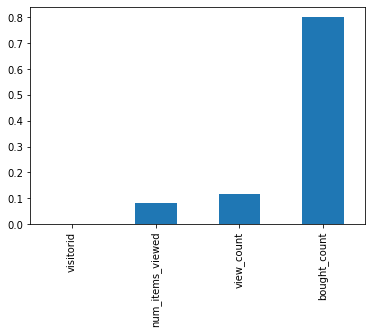

In [200]:
feature_importance=pd.Series(model.feature_importances_,index=x.columns)
feature_importance.plot(kind='bar')

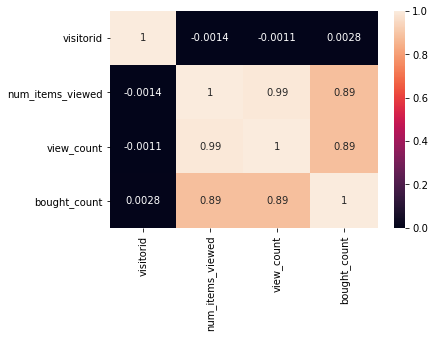

In [201]:
corr=x.corr()
sns.heatmap(corr,annot=True)

In [169]:
X_train, X_test, y_train, y_test = train_test_split(x, y_df, random_state = 42, train_size = 0.7)

In [170]:
model=[]
model.append(('LR',LogisticRegression()))
model.append(('LDA',LinearDiscriminantAnalysis()))
model.append(('DT',DecisionTreeClassifier()))
model.append(('RF',RandomForestClassifier()))
model.append(('NB',GaussianNB()))
model.append(('SVC',SVC()))
model.append(('KNN',KNeighborsClassifier()))
model.append(('XGB',XGBClassifier()))

In [171]:
import warnings
warnings.filterwarnings('ignore')

In [172]:
seed=7
results=[]
names=[]
scoring='accuracy'
for name,models in model:
    kfold=KFold(n_splits=5,random_state=seed)
    cv_results=cross_val_score(models,X_train,y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    final_output=name,cv_results.mean(),cv_results.std()
    print(final_output)

('LR', 0.7443133423374627, 0.12794059498982108)
('LDA', 0.9421383633637014, 0.002729312253062299)
('DT', 1.0, 0.0)
('RF', 1.0, 0.0)
('NB', 0.5234712529045413, 0.004612353122644117)
('SVC', 0.5012148990092319, 0.007156084576113011)
('KNN', 0.5875761437789422, 0.005917396021854975)
('XGB', 1.0, 0.0)


Text(0.5, 0, "['LR', 'LDA', 'DT', 'RF', 'NB', 'SVC', 'KNN', 'XGB']")

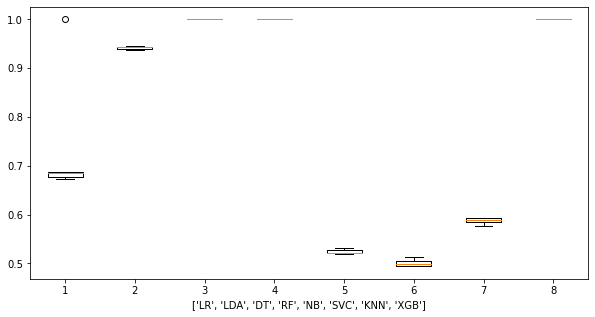

In [173]:
fig=plt.figure(figsize=(10,5))
plt.boxplot(results)
plt.xlabel(names)

In [174]:
model=RandomForestClassifier().fit(X_train,y_train)
predtest=model.predict(X_test)
accuracy_score(y_test,predtest)

1.0

In [175]:
model=RandomForestClassifier().fit(X_train,y_train)
predtrain=model.predict(X_train)
accuracy_score(y_train,predtrain)

1.0

In [176]:
y_test

,purchased
48334,1
20231,0
32603,0
48983,1
37826,0
...,...
20794,1
1968,0
34794,0
14643,0


In [194]:
print(classification_report(y_test,predtest))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8172
           1       1.00      1.00      1.00      8235

    accuracy                           1.00     16407
   macro avg       1.00      1.00      1.00     16407
weighted avg       1.00      1.00      1.00     16407



In [195]:
print(classification_report(y_train,predtrain))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19172
           1       1.00      1.00      1.00     19109

    accuracy                           1.00     38281
   macro avg       1.00      1.00      1.00     38281
weighted avg       1.00      1.00      1.00     38281



In [196]:
cohen_kappa_score(y_train,predtrain)

1.0

In [197]:
cohen_kappa_score(y_test,predtest)

1.0

In [275]:
 #Random forest good accuracy

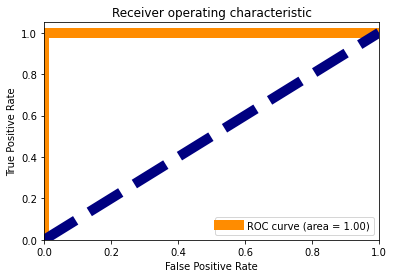

In [190]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 10
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")

In [210]:
pred_test_df=pd.DataFrame(predtest,columns=['predicted'])
visitor_id=X_test['visitorid']
pred_test_df.index=visitor_id

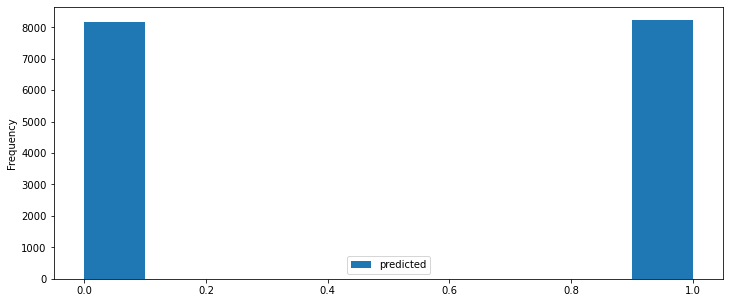

In [212]:
pred_test_df.plot.hist(figsize=(12,5))